Imports

In [132]:
import pandas as pd
import numpy as np

In [133]:
ds = pd.read_csv('falls_vs_normal.csv')
#ds

In [134]:
import random
#print(ds)
def shuffle_data(ds, window_size):
  liste = []
  ds_arr = ds.to_numpy()
  for i in range(0, len(ds_arr), window_size):
    if i % 400 == 0:
      liste.append(ds_arr[i:i+window_size])
  random.shuffle(liste)
  return np.array(liste)
list = shuffle_data(ds, 400)
#print(list)
list.shape


(242, 400, 7)

In [135]:
samples = []
for sample in list:
  for row in sample:
    samples.append(row)
      
data = pd.DataFrame(samples)
#data

In [136]:

def split_observations(data, window_size):
  ds_arr = data.to_numpy()
  #ds_arr = list
  observations = []
  y_values = []

  for i in range(0, len(ds_arr), window_size):
    observation = ds_arr[i:i + window_size, :-1]  # Slice a window, exclude last col
    observations.append(observation)

    # Append y value every window_size (i.e., every 400 values)
    if i % 400 == 0:  # Check for divisibility by 400, not remainder
      y_value = ds_arr[i, -1]
      # Convert string to 1 if it contains "fall", otherwise 0
      y_value = 1 if "fall" in y_value else 0
      y_values.append(y_value)
      #y_values.append(ds_arr[i, -1])  # Append only the last value of the window

  return np.array(observations), np.array(y_values)
        

In [137]:
WINDOW_SIZE = 400
x, y = split_observations(data, WINDOW_SIZE)
#x.shape, y.shape

In [138]:
X_train, y_train = x[:200], y[:200]
X_val, y_val = x[200:220], y[200:220]
X_test, y_test = x[220:], y[220:]
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
#X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
#print(y_train)


In [139]:
from sklearn.preprocessing import LabelEncoder

# Assuming y_train contains string labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)
#y_train.shape, y_val.shape, y_test.shape

In [140]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [141]:
model1 = Sequential()
model1.add(InputLayer((400,6)))
model1.add(LSTM(128, return_sequences=True))
model1.add(LSTM(64, return_sequences=True))
model1.add(LSTM(32, return_sequences=True))
model1.add(LSTM(16))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(1, activation='linear'))
model1.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_72 (LSTM)                  │ (None, 400, 128)       │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ (None, 400, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_74 (LSTM)                  │ (None, 400, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_75 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,369 (524.88 KB)

 Trainable params: 134,369 (524.88 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
cp = ModelCheckpoint('model1/model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=['Accuracy', 'Precision', 'Recall'])

In [143]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 334ms/step - Accuracy: 0.6654 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.3136 - val_Accuracy: 0.6500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.2374
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - Accuracy: 0.7024 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.2024 - val_Accuracy: 0.6500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.1788
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - Accuracy: 0.7362 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.1496 - val_Accuracy: 0.6500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.1400
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - Accuracy: 0.7409 - Precision: 0.7500 - Recall: 0.1313 - loss: 0.1298 - val_Accuracy: 0.8500 - val_Precision: 1.0000 - val_Recall: 0.5714 - val_loss: 0.1080
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - Accuracy: 0.8645 - Precision: 1.0000 - Recall: 0.5684 - loss: 0.1004

In [144]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/model.keras')

In [145]:
#print(len(X_val))
val_predictions = model1.predict(X_val).flatten()
#print(val_predictions)
#print(len(val_predictions))
#print(len(y_val))
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actual':y_val})
#val_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


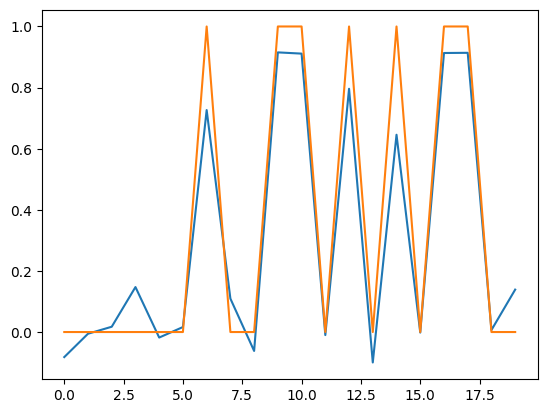

In [146]:
import matplotlib.pyplot as plt
plt.plot(val_results['Val Predictions'][:200])
plt.plot(val_results['Actual'][:200])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


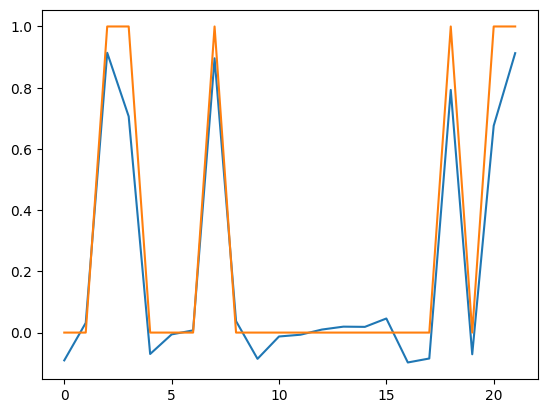

In [147]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actual':y_test})
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actual'])

Flere måder vi kan gøre det her:
- Vi kan vælge hvilke layers der er trainable ved at lave et for loop over model1.layers, også kan vi bare stoppe før de sidste 2 også og sige at de ikke skal være trainable:
  - Presumably you would want to first load pre-trained weights.
      model.load_weights(...)
  - Freeze all layers except the last one. 
        for layer in model.layers[:-1]:
        layer.trainable = False
  - Recompile and train (this will only update the weights of the last layer).
      model.compile(...)
      model.fit(...)
- Næste metode er at træne modellen også fjerne de layers vi vil, prøver herunder:

In [148]:
# Get layers from the trained model:
for i in range(0,2): # sidste 2 layers fordi vi bruger pop
  model1.pop()
model1.summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_72 (LSTM)                  │ (None, 400, 128)       │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ (None, 400, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_74 (LSTM)                  │ (None, 400, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_75 (LSTM)                  │ (None, 16)             │         3,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,820 (1.54 MB)

 Trainable params: 134,080 (523.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 268,740 (1.03 MB)

Shuffle nyt sample og se om vi kan indesætte data fra ny


In [149]:
list2 = shuffle_data(ds, 400)
samples2 = []
for sample in list2:
  for row in sample:
    samples2.append(row)
      
data2 = pd.DataFrame(samples2)
x2, y2 = split_observations(data2, WINDOW_SIZE)
X_train2, y_train2 = x2[:200], y2[:200]
X_val2, y_val2 = x2[200:220], y2[200:220]
X_test2, y_test2 = x2[220:], y2[220:]
X_train2 = X_train2.astype('float32')
X_val2 = X_val2.astype('float32')
X_test2 = X_test2.astype('float32')
y_train2 = encoder.fit_transform(y_train2)
y_val2 = encoder.transform(y_val2)
y_test2 = encoder.transform(y_test2)
model2 = Sequential()
model2.add(InputLayer((400,6)))
model2.add(LSTM(128, return_sequences=True))
model2.add(LSTM(64, return_sequences=True))
model2.add(LSTM(32, return_sequences=True))
model2.add(LSTM(16))
model2.add(Dense(16, activation='relu', name='relu-layer'))
model2.add(Dense(1, activation='linear', name='prediction'))
model2.summary()
cp = ModelCheckpoint('model1/model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=['Accuracy', 'Precision', 'Recall'])
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])
model2 = load_model('model1/model2.keras')

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_76 (LSTM)                  │ (None, 400, 128)       │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_77 (LSTM)                  │ (None, 400, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_78 (LSTM)                  │ (None, 400, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_79 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu-layer (Dense)              │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,369 (524.88 KB)

 Trainable params: 134,369 (524.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - Accuracy: 0.7061 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.2747 - val_Accuracy: 0.6500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.2453
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - Accuracy: 0.7051 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.1909 - val_Accuracy: 0.6500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.1823
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - Accuracy: 0.7652 - Precision: 0.7500 - Recall: 0.1221 - loss: 0.1200 - val_Accuracy: 0.8500 - val_Precision: 1.0000 - val_Recall: 0.5714 - val_loss: 0.1396
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - Accuracy: 0.8730 - Precision: 1.0000 - Recall: 0.5904 - loss: 0.0978 - val_Accuracy: 0.9000 - val_Precision: 1.0000 - val_Recall: 0.7143 - val_loss: 0.1100
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - Accuracy: 0.9236 - Precision: 1.0000 - Recall: 0.7390 - loss: 0.0589 - val_Accuracy:

Graf for den nye model INDEN vi fjerner lag

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


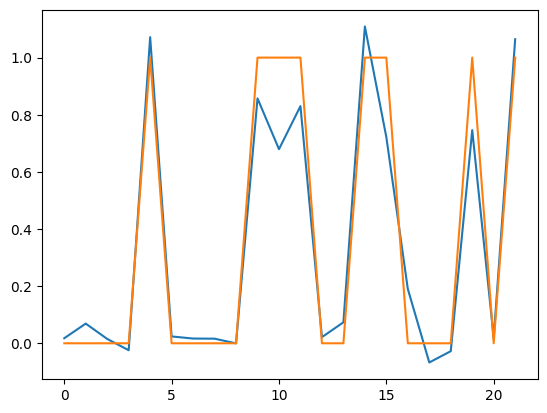

In [150]:
test_predictions2 = model2.predict(X_test2).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions':test_predictions2, 'Actual':y_test2})
plt.plot(test_results2['Test Predictions'])
plt.plot(test_results2['Actual'])

Fjern sidste 2 lag af den nye og tilføje til den gamle.

In [151]:

layers = []
for i in range(0,2): # sidste 2 layers fordi vi bruger pop
  layers.append(model2.pop())

In [152]:
print(layers[0].name)
print(layers[1].name)

prediction
relu-layer


Add layers

In [153]:
model3 = model1
model3.add(layers[1]) # relu lag
model3.add(layers[0]) # prediction layer
model3.summary()
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=['Accuracy', 'Precision', 'Recall'])


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_72 (LSTM)                  │ (None, 400, 128)       │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_73 (LSTM)                  │ (None, 400, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_74 (LSTM)                  │ (None, 400, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_75 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu-layer (Dense)              │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 403,109 (1.54 MB)

 Trainable params: 134,369 (524.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 268,740 (1.03 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


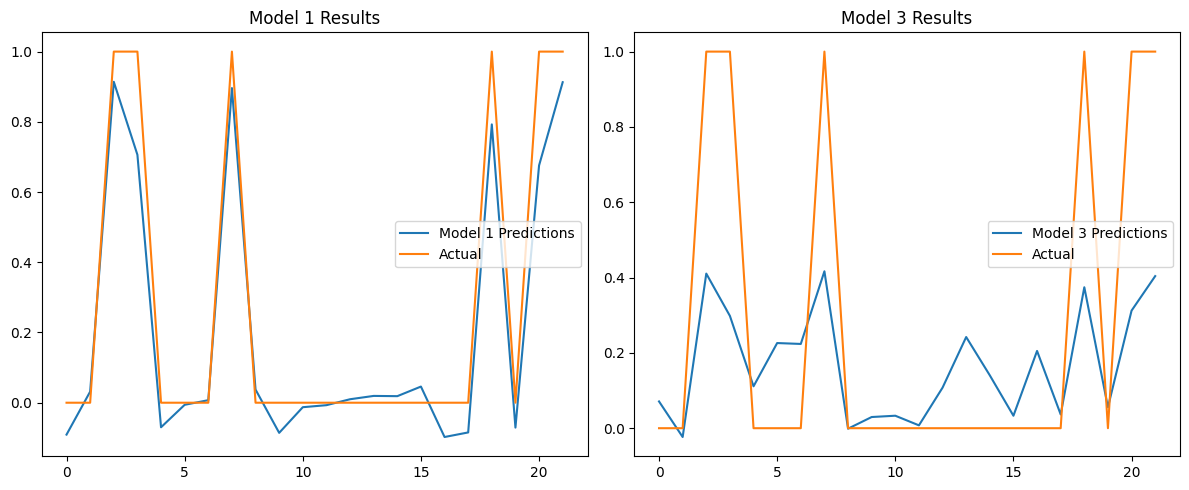

In [154]:
test_predictions3 = model3.predict(X_test).flatten()
test_results3 = pd.DataFrame(data={'Test Predictions':test_predictions3, 'Actual':y_test})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Plot model1 results on the first subplot
ax1.plot(test_results['Test Predictions'], label='Model 1 Predictions')
ax1.plot(test_results['Actual'], label='Actual')
ax1.set_title('Model 1 Results')
ax1.legend()

# Plot model3 results on the second subplot
ax2.plot(test_results3['Test Predictions'], label='Model 3 Predictions')
ax2.plot(test_results3['Actual'], label='Actual')
ax2.set_title('Model 3 Results')
ax2.legend()

# Customize overall figure (optional)
plt.tight_layout()  # Adjust spacing between subplots

# Display the plot
plt.show()